In [1]:
import pandas as pd
from subprocess import call
import seaborn as sns
import numpy as np
from scipy import stats
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import graphviz
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sn
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from xgboost import XGBClassifier
import xgboost as xgb
import warnings
import random
from datetime import datetime
import time
import pickle
from IPython.display import HTML, display
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp


warnings.filterwarnings('ignore')

C:\Users\sandr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\sandr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sandr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#Import the data
data = pd.read_csv(
    "https://ethicallychoice.alwaysdata.net/wp-content/data.csv", sep=";")
#drop the empty line
data = data.dropna()
#convert to int all the datas
for i in ["1", "2"]:
    data["personnage_" + i] = data["personnage_" + i].astype(int)
    data["force_" + i] = data["force_" + i].astype(int)
data["scenarios"] = data["scenarios"].astype(int)

#Import the concentration question
conc = pd.read_csv(
    "https://ethicallychoice.alwaysdata.net/wp-content/conc.csv", sep=";")

#collect people who are bad answering
out = {}
for i in range(len(conc)):
    for j in range(1, 4):
        if conc["q" + str(j)][i] != conc["q" + str(j) + "_rep"][i]:
            if conc.id[i] not in out:
                out[conc.id[i]] = 1
            else:
                out[conc.id[i]] = out[conc.id[i]] + 1
out = [k for (k, v) in out.items() if v > 1]
#collect lines corresponding in data
index = []
for i in range(len(out)):
    index.append(data.index[data["id_participant"] == out[i]].tolist())
#drop lines
for i in range(len(index)):
    for j in range(len(index[i])):
        data.drop(index[i][j], inplace=True)

#We give a number to each participant
data["id_participant"] = np.unique(data["id_participant"],
                                   return_inverse=True)[1]

#Convert to number "Enfant"
data["enfant"] = [0 if i == "Non" else 1 for i in data["enfant"]]

#Associate a number to each gender
data["sexe"] = [
    0 if i == "Femme" else 1 if i == "Homme" else 2 for i in data["sexe"]
]

#We make the assumption that changing the order does not influence people
data2 = data.copy(deep=True)

for s in ["personnage", "force", "task"]:
    data2[s + "_1"] = data[s + "_2"]
    data2[s + "_2"] = data[s + "_1"]

data = pd.concat([data, data2]).reset_index(drop=True)

data

,personnage_1,personnage_2,force_1,force_2,scenarios,task_1,task_2,repetition_question,id_participant,age,sexe,taille,enfant
0,1,5,7,3,4,8,2,1,103,57,0,169,1
1,5,9,3,6,2,1,9,1,103,57,0,169,1
2,5,8,3,8,3,1,9,1,103,57,0,169,1
3,3,5,10,3,9,0,10,1,103,57,0,169,1
4,8,9,8,6,7,5,5,1,103,57,0,169,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6745,9,5,6,4,9,6,4,3,91,22,1,165,0
6746,8,4,8,1,6,9,1,3,91,22,1,165,0
6747,8,3,8,10,8,10,0,3,91,22,1,165,0
6748,5,4,4,1,4,7,3,3,91,22,1,165,0


In [3]:
def classification_report_opti(y_test, y_test_predict):
    classification = {}
    for cl in range(max(y_test) + 1):
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for i in range(len(y_test)):
            if cl > 0 and cl < max(y_test):
                if y_test[i] == cl and y_test_predict[i] in [
                        cl - 1, cl, cl + 1
                ]:
                    tp += 1
                elif y_test[i] == cl and y_test_predict[i] not in [
                        cl - 1, cl, cl + 1
                ]:
                    fn += 1
                elif y_test[i] != cl and y_test_predict[i] in [
                        cl - 1, cl, cl + 1
                ]:
                    fp += 1
                elif y_test[i] != cl and y_test_predict[i] not in [
                        cl - 1, cl, cl + 1
                ]:
                    tn += 1
            elif cl == 0:
                if y_test[i] == cl and y_test_predict[i] in [cl, cl + 1]:
                    tp += 1
                elif y_test[i] == cl and y_test_predict[i] not in [cl, cl + 1]:
                    fn += 1
                elif y_test[i] != cl and y_test_predict[i] in [cl, cl + 1]:
                    fp += 1
                elif y_test[i] != cl and y_test_predict[i] not in [cl, cl + 1]:
                    tn += 1
            elif cl == max(y_test):
                if y_test[i] == cl and y_test_predict[i] in [cl, cl - 1]:
                    tp += 1
                elif y_test[i] == cl and y_test_predict[i] not in [cl, cl - 1]:
                    fn += 1
                elif y_test[i] != cl and y_test_predict[i] in [cl, cl - 1]:
                    fp += 1
                elif y_test[i] != cl and y_test_predict[i] not in [cl, cl - 1]:
                    tn += 1
            classification[cl] = {'TN': tn, 'FN': fn, 'FP': fp, 'TP': tp}

    for i in classification:
        precision = (
            classification[i]['TP'] /
            (classification[i]['TP'] + classification[i]['FP'])
        ) if (classification[i]['TP'] + classification[i]['FP']) != 0 else 0
        recall = (
            classification[i]['TP'] /
            (classification[i]['TP'] + classification[i]['FN'])
        ) if (classification[i]['TP'] + classification[i]['FN']) != 0 else 0
        accuracy = (
            (classification[i]['TP'] + classification[i]['TN']) /
            (classification[i]['TP'] + classification[i]['TN'] +
             classification[i]['FP'] + classification[i]['FN'])
        ) if (classification[i]['TP'] + classification[i]['TN'] +
              classification[i]['FP'] + classification[i]['FN']) != 0 else 0
        classification[i].update({
            'precision': round(precision, 2),
            'recall': round(recall, 2),
            'accuracy': round(accuracy, 2)
        })
        f1_score = (
            2 * (classification[i]['precision'] * classification[i]['recall'])
        ) / (classification[i]['precision'] + classification[i]['recall']) if (
            classification[i]['precision'] +
            classification[i]['recall']) != 0 else 0
        classification[i].update({'f1-score': round(f1_score, 2)})

    num = 0
    denom = 0
    for i in classification:
        num += classification[i]['TP'] + classification[i]['TN']
        denom += classification[i]['TP'] + classification[i][
            'TN'] + classification[i]['FP'] + classification[i]['FN']

    accuracy = num / denom
    classification.update({'accuracy': round(accuracy, 2)})

    print('class | precision | recall | f1-score | accuracy')
    for i in range(max(y_test) + 1):
        print(i, '    | ', classification[i]['precision'], '    | ',
              classification[i]['recall'], ' | ',
              classification[i]['f1-score'], '   | ',
              classification[i]['accuracy'])
    print()
    print('accuracy :    ', classification['accuracy'])

# Répétition 1

## Sans personnages

In [12]:
data_sample = data.copy()
data_sample = data_sample.sample(frac=1)
feature_names = [
    "force_1", "force_2", "scenarios", "age", "sexe"
]
#We get X and y
Y = data_sample[data_sample.repetition_question == 1]["task_1"]
X = data_sample[data_sample.repetition_question == 1][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)


In [13]:
#We get the best parameters for the DT


RFC = RandomForestClassifier(max_depth=10, max_leaf_nodes=95)

# Number of trees in random forest
n_estimators = [(i + 1) * 10 for i in range(10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#We add the other parameters for Random Forest
params = {
    "criterion": ["gini", "entropy","log_loss"],
    'min_samples_split': [2, 3, 4, 8, 10, 16, 32],
    "n_estimators": n_estimators,
    "bootstrap": bootstrap
}

grid_search_cv = GridSearchCV(RFC, params, verbose=1, cv=5, scoring='accuracy', return_train_score=True)
grid_search_cv.fit(X_train, Y_train)
Best_RFC = grid_search_cv.best_estimator_

print("Best score:", grid_search_cv.best_score_)

#saving the model
filename = 'RF1F.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(Best_RFC, open(filename, "wb"))

# loading the model
RF1F = pickle.load(open(filename, 'rb'))

# printing the model
print(RF1F)

#Test on the test set

Y_test_predict_proba = RF1F.predict_proba(X_test)
Y_test_predict = RF1F.predict(X_test)

print("Confusion matrix\n",
      multilabel_confusion_matrix(Y_test, Y_test_predict)[0])

print(
    classification_report(Y_test,
                          Y_test_predict,
                          output_dict=False,
                          target_names=[str(i) for i in range(11)]))

Y_test = pd.concat([Y_test], ignore_index=True)

classification_report_opti(Y_test, Y_test_predict)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best score: 0.42444444444444446
Sauvegarde du modèle dans  RF1F.pkl
RandomForestClassifier(max_depth=10, max_leaf_nodes=95, min_samples_split=3,
                       n_estimators=90)
Confusion matrix
 [[388  23]
 [ 18  21]]
              precision    recall  f1-score   support

           0       0.48      0.54      0.51        39
           1       0.18      0.11      0.13        19
           2       0.21      0.17      0.19        40
           3       0.35      0.19      0.25        37
           4       0.35      0.18      0.24        39
           5       0.46      0.93      0.62        90
           6       0.30      0.14      0.19        42
           7       0.43      0.26      0.32        47
           8       0.35      0.47      0.40        36
           9       0.33      0.05      0.08        22
          10       0.52      0.56      0.54        39

    accuracy                           0.41       450
   mac

In [18]:
turing=pd.DataFrame()
for i in range(5) :
    id=data_fixed[data_fixed.repetition_question != 1].id_participant.sample(n=1)
    if id.keys()[0] in X_test.index:
        turing = pd.concat([turing, data_fixed[data_fixed.id_participant==id.loc[id.keys()[0]]]])
    else :  
        new_id=data_fixed[data_fixed.repetition_question != 1].id_participant.sample(n=1)
        while new_id.keys()[0] not in X_test.index:
            new_id=data_fixed[data_fixed.repetition_question != 1].id_participant.sample(n=1)
        turing = pd.concat([turing, data_fixed[data_fixed.id_participant==new_id.loc[new_id.keys()[0]]]])

    

,task_1 prédite,task_1,force_1,force_2,scenarios,age,sexe
0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,8.0,6.0,3.0,6.0,2.0,57.0,0.0
2,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,NaN,NaN,NaN,NaN,NaN
4,5.0,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1924,NaN,NaN,1.0,5.0,1.0,20.0,0.0
2761,NaN,NaN,1.0,8.0,8.0,24.0,1.0
6130,NaN,NaN,6.0,1.0,6.0,24.0,1.0
1816,NaN,NaN,10.0,1.0,8.0,54.0,0.0


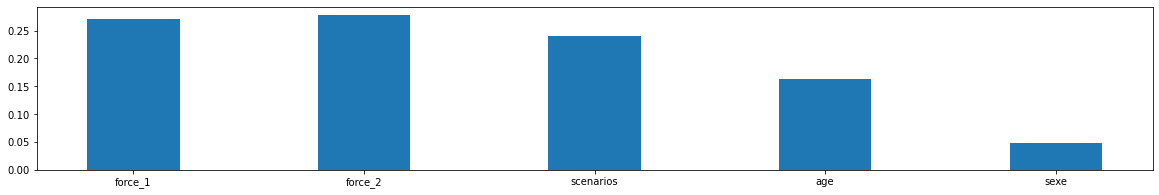

In [6]:
plt.rcParams["figure.figsize"] = (20, 3)

plt.bar(feature_names, RF1F.feature_importances_, width=0.4)
plt.show()

## Avec personnages

In [7]:
feature_names = [
    "personnage_1","personnage_2","force_1", "force_2", "scenarios", "age", "sexe"
]
#We get X and y
Y = data_sample[data_sample.repetition_question == 1]["task_1"]
X = data_sample[data_sample.repetition_question == 1][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)

In [8]:
#We get the best parameters for the DT
RFC = RandomForestClassifier(max_depth=10, max_leaf_nodes=95)

# Number of trees in random forest
n_estimators = [(i + 1) * 10 for i in range(10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#We add the other parameters for Random Forest
params = {
    "criterion": ["gini", "entropy","log_loss"],
    'min_samples_split': [2, 3, 4, 8, 10, 16, 32],
    "n_estimators": n_estimators,
    "bootstrap": bootstrap
}

grid_search_cv = GridSearchCV(RFC, params, verbose=1, cv=5, scoring='accuracy', return_train_score=True)
grid_search_cv.fit(X_train, Y_train)
Best_RFC = grid_search_cv.best_estimator_

print("Best score:", grid_search_cv.best_score_)


#saving the model
filename = 'RF1P.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(Best_RFC, open(filename, "wb"))

# loading the model
RF1P = pickle.load(open(filename, 'rb'))

# printing the model
print(RF1P)

#Test on the test set

Y_test_predict_proba = RF1P.predict_proba(X_test)
Y_test_predict = RF1P.predict(X_test)

print("Confusion matrix\n",
      multilabel_confusion_matrix(Y_test, Y_test_predict)[0])

print(
    classification_report(Y_test,
                          Y_test_predict,
                          output_dict=False,
                          target_names=[str(i) for i in range(11)]))

Y_test = pd.concat([Y_test], ignore_index=True)

classification_report_opti(Y_test, Y_test_predict)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best score: 0.4288888888888889
Sauvegarde du modèle dans  RF1P.pkl
RandomForestClassifier(bootstrap=False, max_depth=10, max_leaf_nodes=95,
                       min_samples_split=8, n_estimators=30)
Confusion matrix
 [[380  32]
 [ 14  24]]
              precision    recall  f1-score   support

           0       0.43      0.63      0.51        38
           1       0.60      0.15      0.24        20
           2       0.22      0.23      0.23        30
           3       0.33      0.22      0.26        37
           4       0.46      0.15      0.23        39
           5       0.53      0.71      0.61       112
           6       0.18      0.17      0.18        35
           7       0.18      0.18      0.18        33
           8       0.28      0.27      0.27        37
           9       0.38      0.16      0.22        19
          10       0.57      0.66      0.61        50

    accuracy                           0.41 

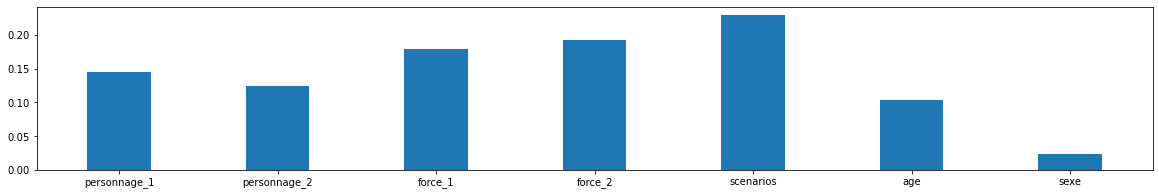

In [9]:
plt.rcParams["figure.figsize"] = (20, 3)

plt.bar(feature_names, RF1P.feature_importances_, width=0.4)
plt.show()

# Répétition 2 avec répétition 1 données

In [21]:
data_rep2 = data.copy()
data_rep2["rep_1"] = 0
for scen in range(1, 10):
    start_time = datetime.now()
    for i in data_rep2[data_rep2.scenarios == scen].index:
        if data_rep2.loc[i].repetition_question == 1:
            rep_1 = data_rep2.loc[i].task_1
            #vérifier que particpant poru rep1 == participant pour rep 2
        elif data_rep2.loc[i].repetition_question == 2:
            data_rep2.loc[i, 'rep_1'] = rep_1

data_rep2[["personnage_1","personnage_2","scenarios","task_1","repetition_question","rep_1"]][data_rep2.repetition_question <3][:18]

,personnage_1,personnage_2,force_1,force_2,scenarios,task_1,task_2,repetition_question,id_participant,age,sexe,taille,enfant,rep_1
0,1,5,7,3,4,8,2,1,103,57,0,169,1,0
1,5,9,3,6,2,1,9,1,103,57,0,169,1,0
2,5,8,3,8,3,1,9,1,103,57,0,169,1,0
3,3,5,10,3,9,0,10,1,103,57,0,169,1,0
4,8,9,8,6,7,5,5,1,103,57,0,169,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6745,9,5,6,4,9,6,4,3,91,22,1,165,0,0
6746,8,4,8,1,6,9,1,3,91,22,1,165,0,0
6747,8,3,8,10,8,10,0,3,91,22,1,165,0,0
6748,5,4,4,1,4,7,3,3,91,22,1,165,0,0


## Sans personnages

In [11]:
data_sample2 = data_rep2.copy()
data_sample2 = data_sample2.sample(frac=1)
feature_names = [
    "force_1", "force_2", "scenarios", "age", "sexe","rep_1"
]
#We get X and y
Y = data_sample2[data_sample2.repetition_question == 2]["task_1"]
X = data_sample2[data_sample2.repetition_question == 2][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)

In [12]:
#We get the best parameters for the DT
RFC = RandomForestClassifier(max_depth=10, max_leaf_nodes=95)

# Number of trees in random forest
n_estimators = [(i + 1) * 10 for i in range(10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#We add the other parameters for Random Forest
params = {
    "criterion": ["gini", "entropy","log_loss"],
    'min_samples_split': [2, 3, 4, 8, 10, 16, 32],
    "n_estimators": n_estimators,
    "bootstrap": bootstrap
}

grid_search_cv = GridSearchCV(RFC, params, verbose=1, cv=5, scoring='accuracy', return_train_score=True)
grid_search_cv.fit(X_train, Y_train)
Best_RFC = grid_search_cv.best_estimator_

print("Best score:", grid_search_cv.best_score_)

#saving the model
filename = 'RF2F.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(Best_RFC, open(filename, "wb"))

# loading the model
RF2F = pickle.load(open(filename, 'rb'))

# printing the model
print(RF2F)

#Test on the test set

Y_test_predict_proba = RF2F.predict_proba(X_test)
Y_test_predict = RF2F.predict(X_test)

print("Confusion matrix\n",
      multilabel_confusion_matrix(Y_test, Y_test_predict)[0])

print(
    classification_report(Y_test,
                          Y_test_predict,
                          output_dict=False,
                          target_names=[str(i) for i in range(11)]))

Y_test = pd.concat([Y_test], ignore_index=True)

classification_report_opti(Y_test, Y_test_predict)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best score: 0.6466666666666667
Sauvegarde du modèle dans  RF2F.pkl
RandomForestClassifier(bootstrap=False, max_depth=10, max_leaf_nodes=95,
                       min_samples_split=3, n_estimators=80)
Confusion matrix
 [[403   7]
 [  6  34]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        40
           1       0.32      0.28      0.30        25
           2       0.52      0.39      0.45        33
           3       0.48      0.56      0.52        48
           4       0.59      0.48      0.53        33
           5       0.79      0.93      0.86       107
           6       0.69      0.61      0.65        33
           7       0.52      0.61      0.56        38
           8       0.59      0.46      0.52        28
           9       0.62      0.43      0.51        23
          10       0.83      0.83      0.83        42

    accuracy                           0.66 

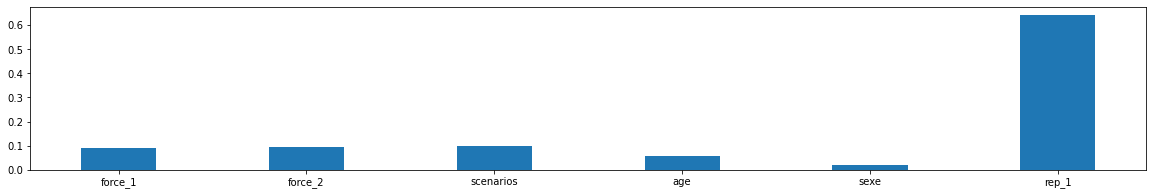

In [13]:
plt.rcParams["figure.figsize"] = (20, 3)

plt.bar(feature_names, RF2F.feature_importances_, width=0.4)
plt.show()

## Avec personnages

In [14]:

feature_names = [
    "personnage_1","personnage_2","force_1", "force_2", "scenarios", "age", "sexe","rep_1"
]
#We get X and y
Y = data_sample2[data_sample2.repetition_question == 2]["task_1"]
X = data_sample2[data_sample2.repetition_question == 2][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)

In [15]:
#We get the best parameters for the DT
RFC = RandomForestClassifier(max_depth=10, max_leaf_nodes=95)

# Number of trees in random forest
n_estimators = [(i + 1) * 10 for i in range(10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#We add the other parameters for Random Forest
params = {
    "criterion": ["gini", "entropy","log_loss"],
    'min_samples_split': [2, 3, 4, 8, 10, 16, 32],
    "n_estimators": n_estimators,
    "bootstrap": bootstrap
}

grid_search_cv = GridSearchCV(RFC, params, verbose=1, cv=5, scoring='accuracy', return_train_score=True)
grid_search_cv.fit(X_train, Y_train)
Best_RFC = grid_search_cv.best_estimator_

print("Best score:", grid_search_cv.best_score_)

#saving the model
filename = 'RF2P.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(Best_RFC, open(filename, "wb"))

# loading the model
RF2P = pickle.load(open(filename, 'rb'))

# printing the model
print(RF2P)

#Test on the test set

Y_test_predict_proba = RF2P.predict_proba(X_test)
Y_test_predict = RF2P.predict(X_test)

print("Confusion matrix\n",
      multilabel_confusion_matrix(Y_test, Y_test_predict)[0])

print(
    classification_report(Y_test,
                          Y_test_predict,
                          output_dict=False,
                          target_names=[str(i) for i in range(11)]))

Y_test = pd.concat([Y_test], ignore_index=True)

classification_report_opti(Y_test, Y_test_predict)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best score: 0.625
Sauvegarde du modèle dans  RF2P.pkl
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_leaf_nodes=95, min_samples_split=3, n_estimators=90)
Confusion matrix
 [[399  11]
 [  6  34]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        40
           1       0.33      0.24      0.28        25
           2       0.43      0.36      0.39        33
           3       0.51      0.48      0.49        48
           4       0.57      0.52      0.54        33
           5       0.72      0.93      0.81       107
           6       0.62      0.45      0.53        33
           7       0.55      0.61      0.57        38
           8       0.69      0.39      0.50        28
           9       0.60      0.26      0.36        23
          10       0.69      0.88      0.77        42

    accuracy                        

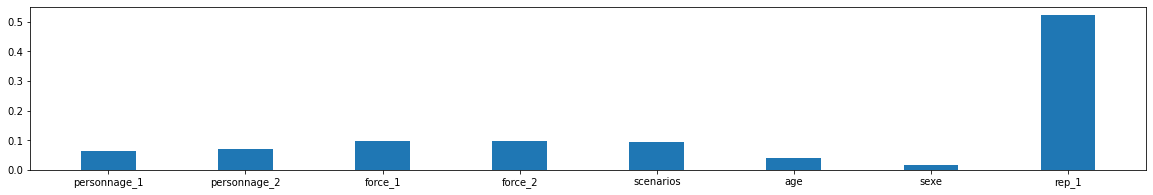

In [16]:
plt.rcParams["figure.figsize"] = (20, 3)

plt.bar(feature_names, RF2P.feature_importances_, width=0.4)
plt.show()

# Répétition 3 avec répétition 1 et 2 données

In [88]:
data_rep3 = data_rep2.copy()
data_rep3["rep_2"] = 0
for scen in range(1, 10):
    start_time = datetime.now()
    for i in data_rep3[data_rep3.scenarios == scen].index:
        if data_rep3.loc[i].repetition_question == 2:
            rep_1 = data_rep3.loc[i].rep_1
            rep_2 = data_rep3.loc[i].task_1
        elif data_rep3.loc[i].repetition_question == 3:
            data_rep3.loc[i, 'rep_1'] = rep_1
            data_rep3.loc[i, 'rep_2'] = rep_2

data_rep3[["personnage_1","personnage_2","scenarios","task_1","repetition_question","rep_1","rep_2"]][data_rep2.repetition_question >1][:18]

,personnage_1,personnage_2,scenarios,task_1,repetition_question,rep_1,rep_2
9,4,5,5,2,2,2,0
10,3,5,9,0,2,0,0
11,5,9,2,1,2,1,0
12,8,9,7,5,2,5,0
13,3,4,8,0,2,0,0
14,4,5,1,5,2,5,0
15,1,5,4,5,2,8,0
16,2,8,6,2,2,2,0
17,5,8,3,1,2,1,0
18,4,5,1,5,3,5,5


## Sans personnages

In [18]:
data_sample3 = data_rep3.copy()
data_sample3 = data_sample3.sample(frac=1)

feature_names = [
    "force_1", "force_2", "scenarios", "age", "sexe","rep_1","rep_2"
]
#We get X and y
Y = data_sample3[data_sample3.repetition_question == 3]["task_1"]
X = data_sample3[data_sample3.repetition_question == 3][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)


In [19]:
#We get the best parameters for the DT
RFC = RandomForestClassifier(max_depth=10, max_leaf_nodes=95)

# Number of trees in random forest
n_estimators = [(i + 1) * 10 for i in range(10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#We add the other parameters for Random Forest
params = {
    "criterion": ["gini", "entropy","log_loss"],
    'min_samples_split': [2, 3, 4, 8, 10, 16, 32],
    "n_estimators": n_estimators,
    "bootstrap": bootstrap
}

grid_search_cv = GridSearchCV(RFC, params, verbose=1, cv=5, scoring='accuracy', return_train_score=True)
grid_search_cv.fit(X_train, Y_train)
Best_RFC = grid_search_cv.best_estimator_

print("Best score:", grid_search_cv.best_score_)

#saving the model
filename = 'RF3F.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(Best_RFC, open(filename, "wb"))

# loading the model
RF3F = pickle.load(open(filename, 'rb'))

# printing the model
print(RF3F)

#Test on the test set

Y_test_predict_proba = RF3F.predict_proba(X_test)
Y_test_predict = RF3F.predict(X_test)

print("Confusion matrix\n",
      multilabel_confusion_matrix(Y_test, Y_test_predict)[0])

print(
    classification_report(Y_test,
                          Y_test_predict,
                          output_dict=False,
                          target_names=[str(i) for i in range(11)]))

Y_test = pd.concat([Y_test], ignore_index=True)

classification_report_opti(Y_test, Y_test_predict)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best score: 0.7483333333333334
Sauvegarde du modèle dans  RF3F.pkl
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_leaf_nodes=95, min_samples_split=3, n_estimators=60)
Confusion matrix
 [[411   3]
 [  2  34]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        36
           1       0.79      0.83      0.81        18
           2       0.65      0.57      0.61        30
           3       0.58      0.74      0.65        35
           4       0.77      0.67      0.71        30
           5       0.86      0.90      0.88       114
           6       0.82      0.59      0.69        39
           7       0.73      0.77      0.75        47
           8       0.68      0.69      0.68        39
           9       0.67      0.50      0.57        20
          10       0.87      0.93      0.90        42

    accuracy           

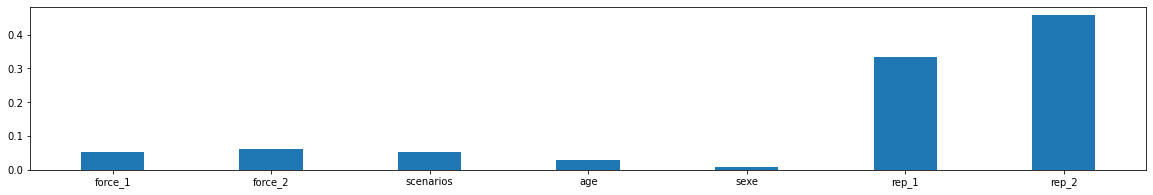

In [20]:
plt.rcParams["figure.figsize"] = (20, 3)

plt.bar(feature_names, RF3F.feature_importances_, width=0.4)
plt.show()

### Catégorie de scénarios

In [89]:
data_rep3['scenarios']= [1 if i < 4 else 2 if (i>3)&(i<7) else 3 for i in data_rep3['scenarios']]

data_rep3

,personnage_1,personnage_2,force_1,force_2,scenarios,task_1,task_2,repetition_question,id_participant,age,sexe,taille,enfant,rep_1,rep_2
0,1,5,7,3,2,8,2,1,103,57,0,169,1,0,0
1,5,9,3,6,1,1,9,1,103,57,0,169,1,0,0
2,5,8,3,8,1,1,9,1,103,57,0,169,1,0,0
3,3,5,10,3,3,0,10,1,103,57,0,169,1,0,0
4,8,9,8,6,3,5,5,1,103,57,0,169,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6745,9,5,6,4,3,6,4,3,91,22,1,165,0,6,6
6746,8,4,8,1,2,9,1,3,91,22,1,165,0,9,9
6747,8,3,8,10,3,10,0,3,91,22,1,165,0,10,10
6748,5,4,4,1,2,7,3,3,91,22,1,165,0,8,7


In [92]:
data_sample3 = data_rep3.copy()
data_sample3 = data_sample3.sample(frac=1)

feature_names = [
    "force_1", "force_2", "scenarios", "age", "sexe","rep_1","rep_2"
]
#We get X and y
Y = data_sample3[data_sample3.repetition_question == 3]["task_1"]
X = data_sample3[data_sample3.repetition_question == 3][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)


In [23]:
#We get the best parameters for the DT
RFC = RandomForestClassifier(max_depth=10, max_leaf_nodes=95)

# Number of trees in random forest
n_estimators = [(i + 1) * 10 for i in range(10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#We add the other parameters for Random Forest
params = {
    "criterion": ["gini", "entropy","log_loss"],
    'min_samples_split': [2, 3, 4, 8, 10, 16, 32],
    "n_estimators": n_estimators,
    "bootstrap": bootstrap
}

grid_search_cv = GridSearchCV(RFC, params, verbose=1, cv=5, scoring='accuracy', return_train_score=True)
grid_search_cv.fit(X_train, Y_train)
Best_RFC = grid_search_cv.best_estimator_

print("Best score:", grid_search_cv.best_score_)

#saving the model
filename = 'RF3_Sclass.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(Best_RFC, open(filename, "wb"))

# loading the model
RF3_Sclass = pickle.load(open(filename, 'rb'))

# printing the model
print(RF3_Sclass)

#Test on the test set

Y_test_predict_proba = RF3_Sclass.predict_proba(X_test)
Y_test_predict = RF3_Sclass.predict(X_test)

print("Confusion matrix\n",
      multilabel_confusion_matrix(Y_test, Y_test_predict)[0])

print(
    classification_report(Y_test,
                          Y_test_predict,
                          output_dict=False,
                          target_names=[str(i) for i in range(11)]))

Y_test = pd.concat([Y_test], ignore_index=True)

classification_report_opti(Y_test, Y_test_predict)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best score: 0.74
Sauvegarde du modèle dans  RF3_Sclass.pkl
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_leaf_nodes=95, min_samples_split=4)
Confusion matrix
 [[405   5]
 [  5  35]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        40
           1       0.95      0.78      0.86        23
           2       0.68      0.68      0.68        28
           3       0.68      0.79      0.73        38
           4       0.84      0.68      0.75        38
           5       0.87      0.88      0.88       126
           6       0.48      0.56      0.52        25
           7       0.78      0.77      0.77        47
           8       0.68      0.63      0.66        30
           9       0.79      0.79      0.79        19
          10       0.90      0.97      0.93        36

    accuracy                           0.80     

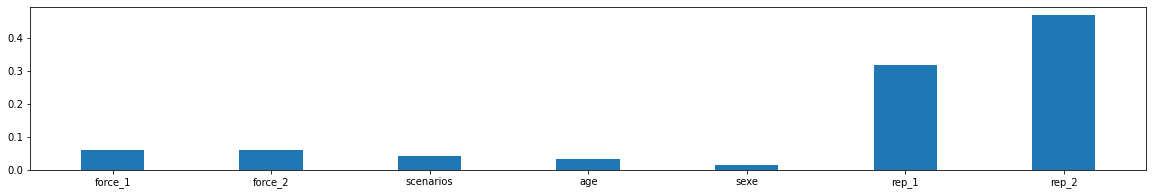

In [24]:
plt.rcParams["figure.figsize"] = (20, 3)

plt.bar(feature_names, RF3_Sclass.feature_importances_, width=0.4)
plt.show()

### Catégorie de force

In [25]:
for i in range(1,3):
    data_rep3['force_'+str(i)]= [1 if i in [1,2,3] else 2 if i in [4,5,6] else 3 if i in [7,8,9] else 4 if i in [10,11,12] else 5 for i in data_rep3['force_'+str(i)]]

data_rep3

,personnage_1,personnage_2,force_1,force_2,scenarios,task_1,task_2,repetition_question,id_participant,age,sexe,taille,enfant,rep_1,rep_2
0,1,5,3,1,2,8,2,1,103,57,0,169,1,0,0
1,5,9,1,2,1,1,9,1,103,57,0,169,1,0,0
2,5,8,1,3,1,1,9,1,103,57,0,169,1,0,0
3,3,5,4,1,3,0,10,1,103,57,0,169,1,0,0
4,8,9,3,2,3,5,5,1,103,57,0,169,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6745,9,5,2,2,3,6,4,3,91,22,1,165,0,6,6
6746,8,4,3,1,2,9,1,3,91,22,1,165,0,9,9
6747,8,3,3,4,3,10,0,3,91,22,1,165,0,10,10
6748,5,4,2,1,2,7,3,3,91,22,1,165,0,8,7


In [26]:
data_sample3 = data_rep3.copy()
data_sample3 = data_sample3.sample(frac=1)

feature_names = [
    "force_1", "force_2", "scenarios", "age", "sexe","rep_1","rep_2"
]
#We get X and y
Y = data_sample3[data_sample3.repetition_question == 3]["task_1"]
X = data_sample3[data_sample3.repetition_question == 3][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)


In [27]:
#We get the best parameters for the DT
RFC = RandomForestClassifier(max_depth=10, max_leaf_nodes=95)

# Number of trees in random forest
n_estimators = [(i + 1) * 10 for i in range(10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#We add the other parameters for Random Forest
params = {
    "criterion": ["gini", "entropy","log_loss"],
    'min_samples_split': [2, 3, 4, 8, 10, 16, 32],
    "n_estimators": n_estimators,
    "bootstrap": bootstrap
}

grid_search_cv = GridSearchCV(RFC, params, verbose=1, cv=5, scoring='accuracy', return_train_score=True)
grid_search_cv.fit(X_train, Y_train)
Best_RFC = grid_search_cv.best_estimator_

print("Best score:", grid_search_cv.best_score_)

#saving the model
filename = 'RF3_Fclass.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(Best_RFC, open(filename, "wb"))

# loading the model
RF3_Fclass = pickle.load(open(filename, 'rb'))

# printing the model
print(RF3_Fclass)

#Test on the test set

Y_test_predict_proba = RF3_Fclass.predict_proba(X_test)
Y_test_predict = RF3_Fclass.predict(X_test)

print("Confusion matrix\n",
      multilabel_confusion_matrix(Y_test, Y_test_predict)[0])

print(
    classification_report(Y_test,
                          Y_test_predict,
                          output_dict=False,
                          target_names=[str(i) for i in range(11)]))

Y_test = pd.concat([Y_test], ignore_index=True)

classification_report_opti(Y_test, Y_test_predict)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best score: 0.7561111111111111
Sauvegarde du modèle dans  RF3_Fclass.pkl
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_leaf_nodes=95, min_samples_split=3)
Confusion matrix
 [[408   9]
 [  2  31]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        33
           1       0.94      0.71      0.81        21
           2       0.52      0.52      0.52        25
           3       0.65      0.57      0.60        46
           4       0.57      0.57      0.57        37
           5       0.85      0.89      0.87       112
           6       0.82      0.64      0.72        42
           7       0.61      0.57      0.59        40
           8       0.55      0.85      0.67        27
           9       0.80      0.64      0.71        25
          10       0.93      0.93      0.93        42

    accuracy                      

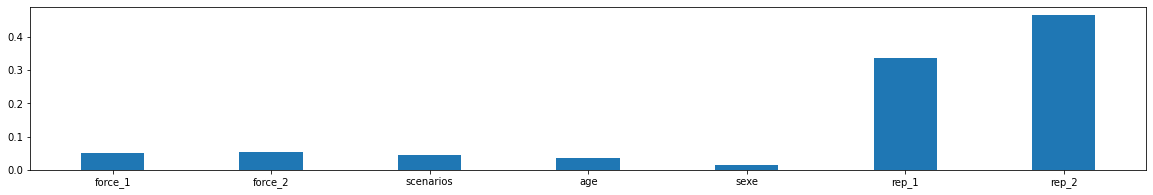

In [28]:
plt.rcParams["figure.figsize"] = (20, 3)

plt.bar(feature_names, RF3_Fclass.feature_importances_, width=0.4)
plt.show()

## Avec personnages

In [109]:
feature_names = [
    "personnage_1","personnage_2","force_1", "force_2", "scenarios", "age", "sexe","rep_1","rep_2"
]
#We get X and y
Y = data_sample3[data_sample3.repetition_question == 3]["task_1"]
X = data_sample3[data_sample3.repetition_question == 3][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)

In [110]:
#We get the best parameters for the DT
RFC = RandomForestClassifier(max_depth=10, max_leaf_nodes=95)

# Number of trees in random forest
n_estimators = [(i + 1) * 10 for i in range(10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#We add the other parameters for Random Forest
params = {
    "criterion": ["gini", "entropy","log_loss"],
    'min_samples_split': [2, 3, 4, 8, 10, 16, 32],
    "n_estimators": n_estimators,
    "bootstrap": bootstrap
}

grid_search_cv = GridSearchCV(RFC, params, verbose=1, cv=5, scoring='accuracy', return_train_score=True)
grid_search_cv.fit(X_train, Y_train)
Best_RFC = grid_search_cv.best_estimator_

print("Best score:", grid_search_cv.best_score_)

#saving the model
filename = 'RF3P.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(Best_RFC, open(filename, "wb"))

# loading the model
RF3P = pickle.load(open(filename, 'rb'))

# printing the model
print(RF3P)

#Test on the test set

Y_test_predict_proba = RF3P.predict_proba(X_test)
Y_test_predict = RF3P.predict(X_test)

print("Confusion matrix\n",
      multilabel_confusion_matrix(Y_test, Y_test_predict)[0])

print(
    classification_report(Y_test,
                          Y_test_predict,
                          output_dict=False,
                          target_names=[str(i) for i in range(11)]))

Y_test = pd.concat([Y_test], ignore_index=True)
X_test=X_test.reset_index()
classification_report_opti(Y_test, Y_test_predict)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best score: 0.7649999999999999
Sauvegarde du modèle dans  RF3P.pkl
RandomForestClassifier(max_depth=10, max_leaf_nodes=95, n_estimators=50)
Confusion matrix
 [[414   6]
 [  3  27]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        30
           1       0.75      0.75      0.75        24
           2       0.73      0.55      0.63        29
           3       0.59      0.71      0.65        31
           4       0.69      0.60      0.64        40
           5       0.82      0.96      0.88       116
           6       0.80      0.49      0.61        41
           7       0.62      0.68      0.65        38
           8       0.75      0.54      0.63        39
           9       0.74      0.85      0.79        20
          10       0.80      0.88      0.84        42

    accuracy                           0.75       450
   macro avg       0.74      0.72      0.72       4

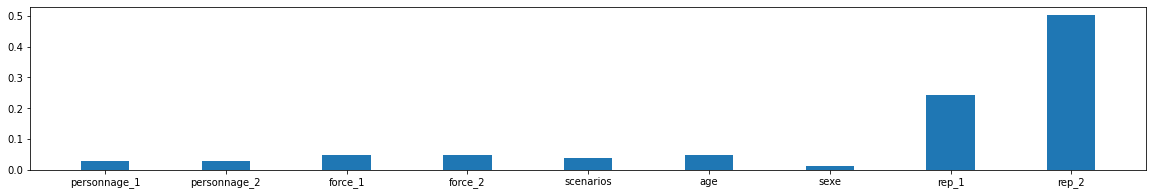

In [111]:
plt.rcParams["figure.figsize"] = (20, 3)

plt.bar(feature_names, RF3P.feature_importances_, width=0.4)
plt.show()

In [112]:
y_pred = pd.Series(Y_test_predict,
                   index=Y_test.index,
                   name='task_1p')
result = pd.concat([y_pred, Y_test, X_test[feature_names]], axis=1)
#newOutput = pd.read_csv('data_rf_.csv', keep_default_na=False, na_values=[""])
result[result.task_1p!=result.task_1].to_csv("data_rf_.csv",sep=";")

# Réseau neurones

In [33]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy


# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import *
from keras.layers import *
from keras.preprocessing import image
from tqdm import tqdm
from keras.models import load_model
from time import time
# Umap 
import umap.plot
from keras.wrappers.scikit_learn import KerasClassifier

In [34]:
def plot_curves_confusion (history,confusion_matrix,class_names):
    plt.figure(1,figsize=(16,6))
    plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)

    # division de la fenêtre graphique en 1 ligne, 3 colonnes,
    # graphique en position 1 - loss fonction

    plt.subplot(1,3,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    # graphique en position 2 - accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')

    # matrice de correlation
    plt.subplot(1,3,3)
    sns.heatmap(conf,annot=True,fmt="d",cmap='Blues',xticklabels=class_names, yticklabels=class_names)# label=class_names)
    # labels, title and ticks
    plt.xlabel('Predicted', fontsize=12)
    #plt.set_label_position('top') 
    #plt.set_ticklabels(class_names, fontsize = 8)
    #plt.tick_top()
    plt.title("Correlation matrix")
    plt.ylabel('True', fontsize=12)
    #plt.set_ticklabels(class_names, fontsize = 8)
    plt.show()

In [82]:
def create_model(optimizer):
    model = models.Sequential()
    model.add(layers.Input(shape=(9,)))
    model.add(layers.Dense(128))
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(256))
    model.add(layers.Dense(256, activation='elu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(512))
    model.add(layers.Dense(512, activation='selu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(11, activation='softmax'))
    print(model.summary())
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy']) 
    return model


In [83]:
start=time()
model = KerasClassifier(build_fn=create_model)
optimizers = ['rmsprop', 'adam','Nadam']
epochs = np.array([64, 128, 216])
batches = np.array([8, 16, 32])
param_grid = dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
feature_names = [
    "personnage_1","personnage_2","force_1", "force_2", "scenarios", "age", "sexe","rep_1","rep_2"
]
#We get X and y
Y = data_sample3[data_sample3.repetition_question == 3]["task_1"]
X = data_sample3[data_sample3.repetition_question == 3][feature_names]

#We obtain train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)

grid_result = grid.fit(X_train, Y_train)


Model: "sequential_1230"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8610 (Dense)          (None, 128)               1280      
                                                                 
 dense_8611 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3553 (Dropout)      (None, 128)               0         
                                                                 
 dense_8612 (Dense)          (None, 256)               33024     
                                                                 
 dense_8613 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3554 (Dropout)      (None, 256)               0         
                                                                 
 dense_8614 (Dense)          (None, 512)           

45/45 [==============================] - 0s 2ms/step - loss: 1.9100 - accuracy: 0.3722
Model: "sequential_1235"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8645 (Dense)          (None, 128)               1280      
                                                                 
 dense_8646 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3568 (Dropout)      (None, 128)               0         
                                                                 
 dense_8647 (Dense)          (None, 256)               33024     
                                                                 
 dense_8648 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3569 (Dropout)      (None, 256)               0         
                              

45/45 [==============================] - 0s 2ms/step - loss: 1.7582 - accuracy: 0.4194
Model: "sequential_1240"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8680 (Dense)          (None, 128)               1280      
                                                                 
 dense_8681 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3583 (Dropout)      (None, 128)               0         
                                                                 
 dense_8682 (Dense)          (None, 256)               33024     
                                                                 
 dense_8683 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3584 (Dropout)      (None, 256)               0         
                              

45/45 [==============================] - 0s 2ms/step - loss: 1.8810 - accuracy: 0.3583
Model: "sequential_1245"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8715 (Dense)          (None, 128)               1280      
                                                                 
 dense_8716 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3598 (Dropout)      (None, 128)               0         
                                                                 
 dense_8717 (Dense)          (None, 256)               33024     
                                                                 
 dense_8718 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3599 (Dropout)      (None, 256)               0         
                              

45/45 [==============================] - 0s 2ms/step - loss: 1.9032 - accuracy: 0.3722
Model: "sequential_1250"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8750 (Dense)          (None, 128)               1280      
                                                                 
 dense_8751 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3613 (Dropout)      (None, 128)               0         
                                                                 
 dense_8752 (Dense)          (None, 256)               33024     
                                                                 
 dense_8753 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3614 (Dropout)      (None, 256)               0         
                              

45/45 [==============================] - 0s 3ms/step - loss: 1.6408 - accuracy: 0.4111
Model: "sequential_1255"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8785 (Dense)          (None, 128)               1280      
                                                                 
 dense_8786 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3628 (Dropout)      (None, 128)               0         
                                                                 
 dense_8787 (Dense)          (None, 256)               33024     
                                                                 
 dense_8788 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3629 (Dropout)      (None, 256)               0         
                              

45/45 [==============================] - 0s 2ms/step - loss: 1.7388 - accuracy: 0.3528
Model: "sequential_1260"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8820 (Dense)          (None, 128)               1280      
                                                                 
 dense_8821 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3643 (Dropout)      (None, 128)               0         
                                                                 
 dense_8822 (Dense)          (None, 256)               33024     
                                                                 
 dense_8823 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3644 (Dropout)      (None, 256)               0         
                              

45/45 [==============================] - 0s 2ms/step - loss: 2.0902 - accuracy: 0.2333
Model: "sequential_1265"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8855 (Dense)          (None, 128)               1280      
                                                                 
 dense_8856 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3658 (Dropout)      (None, 128)               0         
                                                                 
 dense_8857 (Dense)          (None, 256)               33024     
                                                                 
 dense_8858 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3659 (Dropout)      (None, 256)               0         
                              

45/45 [==============================] - 0s 1ms/step - loss: 1.7256 - accuracy: 0.3417
Model: "sequential_1270"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8890 (Dense)          (None, 128)               1280      
                                                                 
 dense_8891 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3673 (Dropout)      (None, 128)               0         
                                                                 
 dense_8892 (Dense)          (None, 256)               33024     
                                                                 
 dense_8893 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3674 (Dropout)      (None, 256)               0         
                              

Total params: 516,491
Trainable params: 516,491
Non-trainable params: 0
_________________________________________________________________
None
45/45 [==============================] - 0s 3ms/step - loss: 1.6275 - accuracy: 0.3889
Model: "sequential_1275"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8925 (Dense)          (None, 128)               1280      
                                                                 
 dense_8926 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3688 (Dropout)      (None, 128)               0         
                                                                 
 dense_8927 (Dense)          (None, 256)               33024     
                                                                 
 dense_8928 (Dense)          (None, 256)               65792     
                   

23/23 [==============================] - 0s 1ms/step - loss: 2.1812 - accuracy: 0.3278
Model: "sequential_1280"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8960 (Dense)          (None, 128)               1280      
                                                                 
 dense_8961 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3703 (Dropout)      (None, 128)               0         
                                                                 
 dense_8962 (Dense)          (None, 256)               33024     
                                                                 
 dense_8963 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3704 (Dropout)      (None, 256)               0         
                              

23/23 [==============================] - 0s 3ms/step - loss: 1.6767 - accuracy: 0.4111
Model: "sequential_1285"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8995 (Dense)          (None, 128)               1280      
                                                                 
 dense_8996 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3718 (Dropout)      (None, 128)               0         
                                                                 
 dense_8997 (Dense)          (None, 256)               33024     
                                                                 
 dense_8998 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3719 (Dropout)      (None, 256)               0         
                              

Total params: 516,491
Trainable params: 516,491
Non-trainable params: 0
_________________________________________________________________
None
23/23 [==============================] - 0s 3ms/step - loss: 1.6795 - accuracy: 0.3944
Model: "sequential_1290"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9030 (Dense)          (None, 128)               1280      
                                                                 
 dense_9031 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3733 (Dropout)      (None, 128)               0         
                                                                 
 dense_9032 (Dense)          (None, 256)               33024     
                                                                 
 dense_9033 (Dense)          (None, 256)               65792     
                   

23/23 [==============================] - 0s 4ms/step - loss: 2.0149 - accuracy: 0.3250
Model: "sequential_1295"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9065 (Dense)          (None, 128)               1280      
                                                                 
 dense_9066 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3748 (Dropout)      (None, 128)               0         
                                                                 
 dense_9067 (Dense)          (None, 256)               33024     
                                                                 
 dense_9068 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3749 (Dropout)      (None, 256)               0         
                              

23/23 [==============================] - 0s 4ms/step - loss: 1.6725 - accuracy: 0.3889
Model: "sequential_1300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9100 (Dense)          (None, 128)               1280      
                                                                 
 dense_9101 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3763 (Dropout)      (None, 128)               0         
                                                                 
 dense_9102 (Dense)          (None, 256)               33024     
                                                                 
 dense_9103 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3764 (Dropout)      (None, 256)               0         
                              

23/23 [==============================] - 0s 2ms/step - loss: 1.6229 - accuracy: 0.4278
Model: "sequential_1305"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9135 (Dense)          (None, 128)               1280      
                                                                 
 dense_9136 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3778 (Dropout)      (None, 128)               0         
                                                                 
 dense_9137 (Dense)          (None, 256)               33024     
                                                                 
 dense_9138 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3779 (Dropout)      (None, 256)               0         
                              

23/23 [==============================] - 0s 2ms/step - loss: 1.9673 - accuracy: 0.3361
Model: "sequential_1310"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9170 (Dense)          (None, 128)               1280      
                                                                 
 dense_9171 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3793 (Dropout)      (None, 128)               0         
                                                                 
 dense_9172 (Dense)          (None, 256)               33024     
                                                                 
 dense_9173 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3794 (Dropout)      (None, 256)               0         
                              

23/23 [==============================] - 0s 4ms/step - loss: 1.8752 - accuracy: 0.2722
Model: "sequential_1315"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9205 (Dense)          (None, 128)               1280      
                                                                 
 dense_9206 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3808 (Dropout)      (None, 128)               0         
                                                                 
 dense_9207 (Dense)          (None, 256)               33024     
                                                                 
 dense_9208 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3809 (Dropout)      (None, 256)               0         
                              

23/23 [==============================] - 0s 1ms/step - loss: 2.1347 - accuracy: 0.2361
Model: "sequential_1320"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9240 (Dense)          (None, 128)               1280      
                                                                 
 dense_9241 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3823 (Dropout)      (None, 128)               0         
                                                                 
 dense_9242 (Dense)          (None, 256)               33024     
                                                                 
 dense_9243 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3824 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 6ms/step - loss: 2.2056 - accuracy: 0.2944
Model: "sequential_1325"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9275 (Dense)          (None, 128)               1280      
                                                                 
 dense_9276 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3838 (Dropout)      (None, 128)               0         
                                                                 
 dense_9277 (Dense)          (None, 256)               33024     
                                                                 
 dense_9278 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3839 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 4ms/step - loss: 1.7507 - accuracy: 0.3806
Model: "sequential_1330"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9310 (Dense)          (None, 128)               1280      
                                                                 
 dense_9311 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3853 (Dropout)      (None, 128)               0         
                                                                 
 dense_9312 (Dense)          (None, 256)               33024     
                                                                 
 dense_9313 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3854 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 4ms/step - loss: 1.7710 - accuracy: 0.3333
Model: "sequential_1335"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9345 (Dense)          (None, 128)               1280      
                                                                 
 dense_9346 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3868 (Dropout)      (None, 128)               0         
                                                                 
 dense_9347 (Dense)          (None, 256)               33024     
                                                                 
 dense_9348 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3869 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 4ms/step - loss: 2.2376 - accuracy: 0.2444
Model: "sequential_1340"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9380 (Dense)          (None, 128)               1280      
                                                                 
 dense_9381 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3883 (Dropout)      (None, 128)               0         
                                                                 
 dense_9382 (Dense)          (None, 256)               33024     
                                                                 
 dense_9383 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3884 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 3ms/step - loss: 1.7697 - accuracy: 0.3611
Model: "sequential_1345"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9415 (Dense)          (None, 128)               1280      
                                                                 
 dense_9416 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3898 (Dropout)      (None, 128)               0         
                                                                 
 dense_9417 (Dense)          (None, 256)               33024     
                                                                 
 dense_9418 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3899 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 3ms/step - loss: 1.8656 - accuracy: 0.3917
Model: "sequential_1350"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9450 (Dense)          (None, 128)               1280      
                                                                 
 dense_9451 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3913 (Dropout)      (None, 128)               0         
                                                                 
 dense_9452 (Dense)          (None, 256)               33024     
                                                                 
 dense_9453 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3914 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 2ms/step - loss: 2.4419 - accuracy: 0.2194
Model: "sequential_1355"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9485 (Dense)          (None, 128)               1280      
                                                                 
 dense_9486 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3928 (Dropout)      (None, 128)               0         
                                                                 
 dense_9487 (Dense)          (None, 256)               33024     
                                                                 
 dense_9488 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3929 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 7ms/step - loss: 1.9746 - accuracy: 0.3389
Model: "sequential_1360"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9520 (Dense)          (None, 128)               1280      
                                                                 
 dense_9521 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3943 (Dropout)      (None, 128)               0         
                                                                 
 dense_9522 (Dense)          (None, 256)               33024     
                                                                 
 dense_9523 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3944 (Dropout)      (None, 256)               0         
                              

12/12 [==============================] - 0s 4ms/step - loss: 2.0864 - accuracy: 0.3417
Model: "sequential_1365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9555 (Dense)          (None, 128)               1280      
                                                                 
 dense_9556 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3958 (Dropout)      (None, 128)               0         
                                                                 
 dense_9557 (Dense)          (None, 256)               33024     
                                                                 
 dense_9558 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3959 (Dropout)      (None, 256)               0         
                              

In [84]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("total time:",time()-start)

Best: 0.420556 using {'batch_size': 16, 'nb_epoch': 64, 'optimizer': 'Nadam'}
total time: 235.15001893043518


In [85]:
BestModel=create_model(grid_result.best_params_['optimizer'],)
epochs=grid_result.best_params_['nb_epoch']
batch_size=grid_result.best_params_['batch_size']
history=BestModel.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size) 

Model: "sequential_1366"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9562 (Dense)          (None, 128)               1280      
                                                                 
 dense_9563 (Dense)          (None, 128)               16512     
                                                                 
 dropout_3961 (Dropout)      (None, 128)               0         
                                                                 
 dense_9564 (Dense)          (None, 256)               33024     
                                                                 
 dense_9565 (Dense)          (None, 256)               65792     
                                                                 
 dropout_3962 (Dropout)      (None, 256)               0         
                                                                 
 dense_9566 (Dense)          (None, 512)           

Epoch 46/64
113/113 [==============================] - 1s 10ms/step - loss: 1.0686 - accuracy: 0.6106 - val_loss: 1.1545 - val_accuracy: 0.5844
Epoch 47/64
113/113 [==============================] - 1s 9ms/step - loss: 1.0624 - accuracy: 0.6233 - val_loss: 1.2231 - val_accuracy: 0.5289
Epoch 48/64
113/113 [==============================] - 1s 9ms/step - loss: 1.0736 - accuracy: 0.6172 - val_loss: 1.2113 - val_accuracy: 0.5667
Epoch 49/64
113/113 [==============================] - 1s 9ms/step - loss: 1.0736 - accuracy: 0.6217 - val_loss: 1.1680 - val_accuracy: 0.6667
Epoch 50/64
113/113 [==============================] - 1s 9ms/step - loss: 1.0725 - accuracy: 0.6311 - val_loss: 1.2411 - val_accuracy: 0.5689
Epoch 51/64
113/113 [==============================] - 1s 10ms/step - loss: 1.0858 - accuracy: 0.6228 - val_loss: 1.1658 - val_accuracy: 0.5956
Epoch 52/64
113/113 [==============================] - 1s 9ms/step - loss: 1.0678 - accuracy: 0.6294 - val_loss: 1.0681 - val_accuracy: 0.59

Accuracy sur le jeu de test 0.5822222222222222


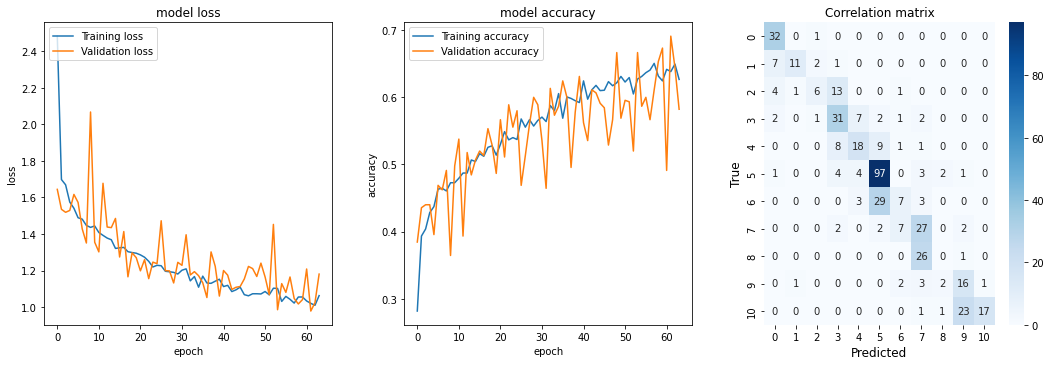

class | precision | recall | f1-score | accuracy
0     |  0.54     |  0.97  |  0.69    |  0.94
1     |  0.29     |  0.95  |  0.44    |  0.89
2     |  0.24     |  0.8  |  0.37    |  0.85
3     |  0.39     |  0.85  |  0.53    |  0.85
4     |  0.15     |  0.95  |  0.26    |  0.56
5     |  0.53     |  0.9  |  0.67    |  0.78
6     |  0.17     |  0.93  |  0.29    |  0.58
7     |  0.38     |  0.85  |  0.53    |  0.86
8     |  0.24     |  1.0  |  0.39    |  0.81
9     |  0.29     |  0.76  |  0.42    |  0.88
10     |  0.66     |  0.95  |  0.78    |  0.95

accuracy :     0.81


In [86]:
predict_y=BestModel.predict(X_test) 
y_pred=np.argmax(predict_y,axis=1)
Y_test = pd.concat([Y_test], ignore_index=True)

print("Accuracy sur le jeu de test", accuracy_score(Y_test, y_pred))

conf=confusion_matrix(Y_test,y_pred)
plot_curves_confusion (history,conf,range(11))
classification_report_opti(Y_test, y_pred)

In [87]:
# prédiction avec le modèle chargé 
nb_images=15
predict_y=BestModel.predict(X_test[0:nb_images])
Y_test = pd.concat([Y_test], ignore_index=True)
y_pred=np.argmax(predict_y,axis=1)
for i in range(0,len(y_pred)):
    print ("Classe réelle  ", Y_test[i], " - classe prédite", y_pred[i] )


Classe réelle   2  - classe prédite 3
Classe réelle   1  - classe prédite 1
Classe réelle   5  - classe prédite 5
Classe réelle   1  - classe prédite 0
Classe réelle   5  - classe prédite 5
Classe réelle   3  - classe prédite 3
Classe réelle   2  - classe prédite 0
Classe réelle   10  - classe prédite 10
Classe réelle   3  - classe prédite 3
Classe réelle   6  - classe prédite 5
Classe réelle   3  - classe prédite 6
Classe réelle   5  - classe prédite 5
Classe réelle   5  - classe prédite 5
Classe réelle   3  - classe prédite 3
Classe réelle   5  - classe prédite 5
